### Purpose of this task
is to estimate an usplift/downlift (if detected), by performing statistical testing over a given data source, to compare Variant versus Control in the current feature implementation.

### What is available
Swimlanes is a widget on a listing page that recommends restaurants atop the normal list of **all restaurants** available below. 

The widget can come in different configurations:
 - "Reorder from the restaurants you love""
 - "Discover new"
 - "Fast delivery"
 -  etc.
 
 <img src="swimlanes.png"> 




For the sake of example we are testing Control (no swimlanes widget) vs. Variant ("New restaurants") 
After users click on the swimlanes tile, they are being redirected to the restaurant page with the menu of items available to order.


Tested timeframe 01 June - 30 June


### We are interested in such metrics:

- Comparison of conversion rate in session (CVR) for the users that had and did not have swimlanes widget
- Microconversion (mOCVR2) that is defined as users' path in the funnel --> "list" page to "restaurant details page" (that shows how often users proceed to the next step on a platform)

### Task
Perform statistical testing and answer such questions:

- Does Variant have *significant* increase/decrease in the metrics we want to test over the Control?
- Are there any differences between the segments? (platform)
- What is the p-value for experiment runtime and does it maintain the same dynamic over the reported timeframe?
- What is the relative uplift/downlift (in %) for the Variant when compared to Control?
- Calculate the standard deviation for this dataset





In [21]:
%matplotlib inline
import pandas as pd
import numpy as np
import math
import scipy
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

In [22]:

def conversion_rate(test):
    return test[1] / test[0]


def conversion_rate_uncertainty(test):
    c = conversion_rate(test)
    return math.sqrt((c * (1 - c)) / test[0])


def conversion_uplift(control, test):
    c = conversion_rate(control)
    t = conversion_rate(test)
    return (t-c)/c


def z_score(test, test_unc, control, control_unc):
    return (test - control) / math.sqrt(test_unc**2 + control_unc**2)


def p_value(z_score):
    return scipy.stats.norm.sf(abs(z_score))


def ab_test(control, *args, p=0.05):
    conversion_rate_c = conversion_rate(control)
    conversion_rate_cu = conversion_rate_uncertainty(control)
    print('CONTROL:')
    print('conversion rate:\t{0} ± {1}'.format(round(conversion_rate_c, 4),
                                                round(conversion_rate_cu, 4)))
    print('threshhold p-value:\t{0}\n'.format(p))

    for i, test in enumerate(args):
        conversion_rate_t = conversion_rate(test)
        conversion_rate_tu = conversion_rate_uncertainty(test)

        uplift = conversion_uplift(control, test)

        Z = z_score(conversion_rate_t, conversion_rate_tu,
                    conversion_rate_c, conversion_rate_cu)

        P = p_value(Z)

        better_than_control = True if uplift > 0 else False
        significant_test = True if P < p else False

        print((80*'-' + '\nTEST {}\n' + 80*'-') .format(i+1))

        if not significant_test:
            print('We can\'t say anything significant '
                  'about how well the test performed')

        if significant_test and better_than_control:
            print('The test performed better than the '
                  'control by a significant margin!')

        if significant_test and not better_than_control:
            print('The test performed worse than the '
                  'control by a significant margin.')

        print('conversion rate:\t{} ± {}'.format(round(conversion_rate_t, 4),
                                                  round(conversion_rate_tu, 4)))
        print('uplift:\t\t\t' + str(round(uplift, 4)))
        print('Z-score:\t\t' + str(round(Z, 4)))
        print('p-value:\t\t' + str(round(P, 8)))
        print()
        
def ab_test_date(control, *args, p=0.05):
    conversion_rate_c = conversion_rate(control)
    conversion_rate_cu = conversion_rate_uncertainty(control) 
    for i, test in enumerate(args):
        conversion_rate_t = conversion_rate(test)
        conversion_rate_tu = conversion_rate_uncertainty(test)

        uplift = conversion_uplift(control, test)

        Z = z_score(conversion_rate_t, conversion_rate_tu,
                    conversion_rate_c, conversion_rate_cu)

        P = p_value(Z)
        return P

In [23]:
df = pd.read_csv("swimlanes.csv")
df.head(20)

,date,platform,variant,experiment_name,mOCVR2,orders,sessions
0,2019-06-28,Android,Control,swimlanes,36.085,73043,466229
1,2019-06-28,Android,Variant,swimlanes,36.094,73104,466516
2,2019-06-28,iOS,Variant,swimlanes,33.756,134223,632095
3,2019-06-19,Android,Control,swimlanes,36.274,64958,379314
4,2019-06-19,iOS,Variant,swimlanes,35.146,119996,506810
5,2019-06-19,Android,Variant,swimlanes,36.287,65024,379577
6,2019-06-12,Android,Control,swimlanes,36.511,56769,341028
7,2019-06-12,iOS,Variant,swimlanes,34.977,96236,472226
8,2019-06-12,Android,Variant,swimlanes,36.522,56836,341337
9,2019-06-18,Android,Control,swimlanes,36.308,61256,360279


In [24]:
df.describe()

,mOCVR2,orders,sessions
count,75.000,75.000,75.000
mean,34.906,80322.227,436939.320
std,1.061,27215.544,98942.044
min,32.657,45730.000,290002.000
25%,34.131,59702.500,356184.000
50%,34.977,70973.000,442748.000
75%,35.677,103985.000,474805.000
max,36.730,134223.000,707474.000


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 7 columns):
date               75 non-null object
platform           75 non-null object
variant            75 non-null object
experiment_name    75 non-null object
mOCVR2             75 non-null float64
orders             75 non-null int64
sessions           75 non-null int64
dtypes: float64(1), int64(2), object(4)
memory usage: 4.2+ KB


In [26]:
# Look at the variables in detail and examine the number of unique observation on each variable

for item in df.columns:
    print(item)
    print (df[item].unique())

date
['2019-06-28' '2019-06-19' '2019-06-12' '2019-06-18' '2019-06-16'
 '2019-06-26' '2019-06-25' '2019-06-04' '2019-06-08' '2019-06-07'
 '2019-06-27' '2019-06-05' '2019-06-17' '2019-06-21' '2019-06-01'
 '2019-06-11' '2019-06-14' '2019-06-24' '2019-06-13' '2019-06-02'
 '2019-06-29' '2019-06-20' '2019-06-06' '2019-06-22' '2019-06-30']
platform
['Android' 'iOS']
variant
['Control' 'Variant']
experiment_name
['swimlanes']
mOCVR2
[36.08479499 36.0941997  33.75561539 36.27378651 35.14644069 36.28697804
 36.51142572 34.97734325 36.52219276 36.30819632 35.20304091 36.3215065
 34.30451004 35.38138038 34.31981313 35.68262895 33.54341259 35.67141928
 35.50065328 33.06707737 35.49076279 33.2714106  33.09543249 33.26011254
 34.81177753 35.59612932 35.60888671 34.12284929 34.77232095 34.7557462
 36.06375375 33.68461337 36.07391883 33.9482864  33.45507516 33.93152484
 34.85233956 35.2495042  34.83685936 34.96466851 34.95198484 33.46760575
 33.60355417 34.03196648 33.61915694 36.09688426 36.11369772 

In [27]:
# add a column for conversion rate and column for restaurant detail sessions so mOCVR2 can be calculated 
# using its constituent components

df['conversion_rate'] = df['orders'] / df['sessions']
df['restaurant_detail_sessions'] = df['sessions']*(df['mOCVR2']/100)
df.head(20)

,date,platform,variant,experiment_name,mOCVR2,orders,sessions,conversion_rate,restaurant_detail_sessions
0,2019-06-28,Android,Control,swimlanes,36.085,73043,466229,0.157,168237.779
1,2019-06-28,Android,Variant,swimlanes,36.094,73104,466516,0.157,168385.217
2,2019-06-28,iOS,Variant,swimlanes,33.756,134223,632095,0.212,213367.557
3,2019-06-19,Android,Control,swimlanes,36.274,64958,379314,0.171,137591.551
4,2019-06-19,iOS,Variant,swimlanes,35.146,119996,506810,0.237,178125.676
5,2019-06-19,Android,Variant,swimlanes,36.287,65024,379577,0.171,137737.023
6,2019-06-12,Android,Control,swimlanes,36.511,56769,341028,0.166,124514.185
7,2019-06-12,iOS,Variant,swimlanes,34.977,96236,472226,0.204,165172.109
8,2019-06-12,Android,Variant,swimlanes,36.522,56836,341337,0.167,124663.757
9,2019-06-18,Android,Control,swimlanes,36.308,61256,360279,0.170,130810.807


In [28]:
# find the overall conversion rate

overall_conversion_rate = sum( df['orders']) / sum(df['sessions'])
print(overall_conversion_rate)

# find overall mOCVR2

overall_mocvr2 = sum(df['restaurant_detail_sessions'])/sum(df['sessions'])
print(overall_mocvr2)

0.18382924811313997
0.34873955470489504


_What is the standard deviation for this dataset?_

Since this dataset features conversions such as orders and navigation to details page, the user either performed a conversion action or did not (either 1 or 0). So, we can model this as a Bernoulli trial. The probability of the event happening will be the conversion rate of the relevant event (p). So the standard deviation would be square root of p(1-p).

In [29]:
standard_deviation_cr = math.sqrt(overall_conversion_rate*(1-overall_conversion_rate))

standard_deviation_mocvr2 = math.sqrt(overall_mocvr2*(1-overall_mocvr2))

print(f"The standard deviation for conversion rate is {round(standard_deviation_cr, 3)}.")
print(f"The standard deviation for mOCVR2 is {round(standard_deviation_mocvr2, 3)}.")

The standard deviation for conversion rate is 0.387.
The standard deviation for mOCVR2 is 0.477.


In [30]:
df_timeplot = df.groupby(['date', 'variant', 'platform', 'experiment_name']).agg({'sessions': ['sum'], 'orders': ['sum']})
df_timeplot['conversion_rate'] = df_timeplot['orders'] / df_timeplot['sessions']
df_timeplot = df_timeplot.unstack(1).drop(columns=['sessions', 'orders']).unstack(1)
df_timeplot.reset_index(drop=False)
df_timeplot.head(5)


conversion_rate                  
                                                            
variant                            Control     Variant      
platform                           Android iOS Android   iOS
date       experiment_name                                  
2019-06-01 swimlanes                 0.169 nan   0.169 0.226
2019-06-02 swimlanes                 0.168 nan   0.169 0.230
2019-06-04 swimlanes                 0.158 nan   0.158 0.220
2019-06-05 swimlanes                 0.146 nan   0.146 0.213
2019-06-06 swimlanes                 0.154 nan   0.154 0.224

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000021ED363C358>,
      dtype=object)

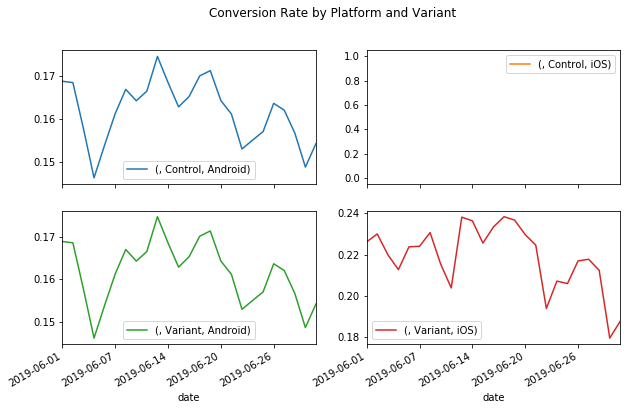

In [31]:
# Use subplots to examine conversion rate across platforms, for both control and variant

df_timeplot.reset_index().plot(x='date', y='conversion_rate', subplots=True, layout=(2,2), figsize=(10, 6),
                              title = ('Conversion Rate by Platform and Variant'))

_-Does Variant have significant increase/decrease in the conversion rate over the Control?_

_-Are there any differences between the segments? (platform)_

We need to break each metric (conversion rate, mOCVR2) by segments in order to observe useful increases/decreases between variance and control.
As we have observed, the control on iOS is not available so a direct comparison by platform (android variant vs control, iOS variant vs control) is not suitable. 

Based on the plot above, for conversion rate on Android platform, the variance does not appear to have any significant difference when comparing against the control.
The conversion rates on iOS variant are significantly higher than that on the Android variant.

In [32]:
df_timeplot2 = df.groupby(['date', 'variant', 'platform', 'experiment_name']).agg({'sessions': ['sum'], 'restaurant_detail_sessions': ['sum']})
df_timeplot2['calc_mOVCR2'] = df_timeplot2['restaurant_detail_sessions'] / df_timeplot2['sessions']
df_timeplot2 = df_timeplot2.unstack(1).drop(columns=['sessions', 'restaurant_detail_sessions']).unstack(1)
df_timeplot2.reset_index(drop=False)
df_timeplot2.head(20)


calc_mOVCR2                  
                                                        
variant                        Control     Variant      
platform                       Android iOS Android   iOS
date       experiment_name                              
2019-06-01 swimlanes             0.336 nan   0.336 0.340
2019-06-02 swimlanes             0.346 nan   0.346 0.350
2019-06-04 swimlanes             0.333 nan   0.333 0.331
2019-06-05 swimlanes             0.339 nan   0.339 0.335
2019-06-06 swimlanes             0.344 nan   0.344 0.338
2019-06-07 swimlanes             0.348 nan   0.348 0.341
2019-06-08 swimlanes             0.356 nan   0.356 0.348
2019-06-11 swimlanes             0.361 nan   0.361 0.342
2019-06-12 swimlanes             0.365 nan   0.365 0.350
2019-06-13 swimlanes             0.367 nan   0.367 0.355
2019-06-14 swimlanes             0.327 nan   0.327 0.346
2019-06-16 swimlanes             0.343 nan   0.343 0.354
2019-06-17 swimlanes             0.348 nan   0.349 0.352
2019-06-18 swimlanes             0.363 nan   0.363 0.352
2019-06-19 swimlanes             0.363 nan   0.363 0.351
2019-06-20 swimlanes             0.356 nan   0.356 0.343
2019-06-21 swimlanes             0.350 nan   0.350 0.335
2019-06-22 swimlanes             0.354 nan   0.354 0.341
2019-06-24 swimlanes             0.351 nan   0.351 0.331
2019-06-25 swimlanes             0.355 nan   0.355 0.331

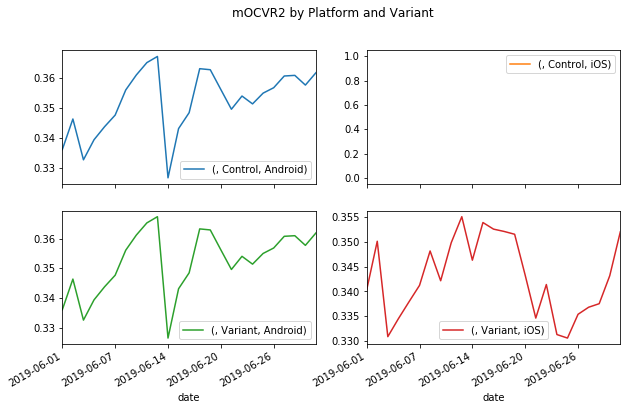

In [33]:
df_timeplot2.reset_index().plot(x='date', y='calc_mOVCR2', subplots=True, layout=(2,2), figsize=(10,6),  
                                title = ('mOCVR2 by Platform and Variant'))
[ax.legend(loc=0) for ax in plt.gcf().axes]
plt.show()

_-Does Variant have significant increase/decrease in mOCVR2 over the Control?_

_-Are there any differences between the segments? (platform)_

As we have observed, the control on iOS is not available.

For mOCVR2 on Android platform, the variance does not appear to have any significant difference when comparing against the control.
The mOCVR2 rates on iOS variant are slightly lower than those on Android. 

iOS has no metrics specified for control. So, we can't do any A/B test comparisons unless we compare iOS against the Android control.

In [34]:
# aggregate metrics to compare between variant and control

pd.options.display.float_format = '{:.3f}'.format
cr = df.groupby('variant').agg({'sessions': ['sum'], 'orders': ['sum'], 'restaurant_detail_sessions': ['sum']})
cr['conversion_rate'] = cr['orders']/cr['sessions']
cr['mOCVR2_calc'] = cr['restaurant_detail_sessions']/cr['sessions']
cr = cr.drop(columns=['sessions', 'orders', 'restaurant_detail_sessions'])
cr = cr.T
# cr.columns = ['_'.join(tup).rstrip('_') for tup in cr.columns.values]
cr['uplift'] = ((cr['Variant']/cr['Control'])-1)*100
cr

,variant,Control,Variant,uplift
conversion_rate,,0.161,0.193,19.977
mOCVR2_calc,,0.353,0.347,-1.620


In [35]:
# break down by platform and calculate uplift

metrics_breakdown = df.groupby(['experiment_name', 'platform', 'variant']).agg({'sessions': ['sum'], 'orders': ['sum'], 'restaurant_detail_sessions': ['sum']})
metrics_breakdown['conversion_rate'] = metrics_breakdown['orders']/metrics_breakdown['sessions']
metrics_breakdown['mOCVR2_calc'] = metrics_breakdown['restaurant_detail_sessions']/metrics_breakdown['sessions']
metrics_breakdown = metrics_breakdown.drop(columns=['sessions', 'orders', 'restaurant_detail_sessions'])
metrics_breakdown = metrics_breakdown.T
metrics_breakdown.columns = ['_'.join(tup).rstrip('_') for tup in metrics_breakdown.columns.values]
metrics_breakdown['swimlanes_Android_uplift'] = ((metrics_breakdown['swimlanes_Android_Variant']/metrics_breakdown['swimlanes_Android_Control'])-1)*100
metrics_breakdown['swimlanes_iOS_uplift'] = ((metrics_breakdown['swimlanes_iOS_Variant']/metrics_breakdown['swimlanes_Android_Control'])-1)*100
metrics_breakdown

,,swimlanes_Android_Control,swimlanes_Android_Variant,swimlanes_iOS_Variant,swimlanes_Android_uplift,swimlanes_iOS_uplift
conversion_rate,,0.161,0.161,0.217,0.032,34.631
mOCVR2_calc,,0.353,0.353,0.343,0.036,-2.838


In [36]:
# What is the relative uplift/downlift (in %) for the Variant when compared to Control?

print(f"Overall, without breaking down by platform, the relative conversion rate uplift/downlift for the variant is {round(cr['uplift'][0], 3)}%. The corresponding change for mOCVR2 is {round(cr['uplift'][1], 3)}%. However, this can be misleading so we need to compare by each specific platform.")

print(f"The relative conversion rate uplift/downlift for the android variant is {round(metrics_breakdown['swimlanes_Android_uplift'][0], 3)}%.")
print(f"The relative mOCVR2 uplift/downlift for the android variant is {round(metrics_breakdown['swimlanes_Android_uplift'][1], 3)}%.")

print(f"The relative conversion rate uplift/downlift for the iOS variant (compared to Android control) is {round(metrics_breakdown['swimlanes_iOS_uplift'][0], 3)}%.")
print(f"The relative mOCVR2 uplift/downlift for the iOS variant (compared to Android control) is {round(metrics_breakdown['swimlanes_iOS_uplift'][1], 3)}%.") 
print("Since more than one variable was changed (ie the platform is different), this may not be considered a valid test for the iOS platform.")

Overall, without breaking down by platform, the relative conversion rate uplift/downlift for the variant is 19.977%. The corresponding change for mOCVR2 is -1.62%. However, this can be misleading so we need to compare by each specific platform.
The relative conversion rate uplift/downlift for the android variant is 0.032%.
The relative mOCVR2 uplift/downlift for the android variant is 0.036%.
The relative conversion rate uplift/downlift for the iOS variant (compared to Android control) is 34.631%.
The relative mOCVR2 uplift/downlift for the iOS variant (compared to Android control) is -2.838%.
Since more than one variable was changed (ie the platform is different), this may not be considered a valid test for the iOS platform.


In [37]:
# trended total of sessions and orders, in order to calculate conversion_rate by date for each platform

df_trended_cr = df.groupby(['date', 'variant', 'platform', 'experiment_name']).agg({'sessions': ['sum'], 'orders': ['sum'], 'restaurant_detail_sessions': ['sum']})
df_trended_cr = df_trended_cr.unstack(1).unstack(1)
df_trended_cr.columns = ['_'.join(tup).rstrip('_') for tup in df_trended_cr.columns.values]
df_trended_cr['sessions_cumsum_control_android'] = df_trended_cr.sessions_sum_Control_Android.cumsum()
df_trended_cr['sessions_cumsum_control_ios'] = df_trended_cr.sessions_sum_Control_iOS.cumsum()
df_trended_cr['sessions_cumsum_variant_android'] = df_trended_cr.sessions_sum_Variant_Android.cumsum()
df_trended_cr['sessions_cumsum_variant_ios'] = df_trended_cr.sessions_sum_Variant_iOS.cumsum()
df_trended_cr['orders_cumsum_control_android'] = df_trended_cr.orders_sum_Control_Android.cumsum()
df_trended_cr['orders_cumsum_control_ios'] = df_trended_cr.orders_sum_Control_iOS.cumsum()
df_trended_cr['orders_cumsum_variant_android'] = df_trended_cr.orders_sum_Variant_Android.cumsum()
df_trended_cr['orders_cumsum_variant_ios'] = df_trended_cr.orders_sum_Variant_iOS.cumsum()
df_trended_cr['restaurant_detail_cumsum_control_android'] = df_trended_cr.restaurant_detail_sessions_sum_Control_Android.cumsum()
df_trended_cr['restaurant_detail_cumsum_control_ios'] = df_trended_cr.restaurant_detail_sessions_sum_Control_iOS.cumsum()
df_trended_cr['restaurant_detail_cumsum_variant_android'] = df_trended_cr.restaurant_detail_sessions_sum_Variant_Android.cumsum()
df_trended_cr['restaurant_detail_cumsum_variant_ios'] = df_trended_cr.restaurant_detail_sessions_sum_Variant_iOS.cumsum()


df_trended_cr = df_trended_cr.drop(columns=['sessions_sum_Control_Android', 
                            'sessions_sum_Control_iOS',
                           'sessions_sum_Variant_Android',
                           'sessions_sum_Variant_iOS',
                           'orders_sum_Control_Android',
                           'orders_sum_Control_iOS',
                           'orders_sum_Variant_Android',
                           'orders_sum_Variant_iOS',
                           'restaurant_detail_sessions_sum_Control_Android',
                           'restaurant_detail_sessions_sum_Control_iOS',
                           'restaurant_detail_sessions_sum_Variant_Android',
                           'restaurant_detail_sessions_sum_Variant_iOS'])

df_trended_cr

,,sessions_cumsum_control_android,sessions_cumsum_control_ios,sessions_cumsum_variant_android,sessions_cumsum_variant_ios,orders_cumsum_control_android,orders_cumsum_control_ios,orders_cumsum_variant_android,orders_cumsum_variant_ios,restaurant_detail_cumsum_control_android,restaurant_detail_cumsum_control_ios,restaurant_detail_cumsum_variant_android,restaurant_detail_cumsum_variant_ios
date,experiment_name,,,,,,,,,,,,
2019-06-01,swimlanes,322469.000,nan,322784.000,465489.000,54424.000,nan,54502.000,105284.000,108361.045,nan,108517.260,158415.060
2019-06-02,swimlanes,629182.000,nan,629808.000,938429.000,106093.000,nan,106247.000,214080.000,214561.887,nan,214880.545,323974.026
2019-06-04,swimlanes,919184.000,nan,920093.000,1340900.000,151823.000,nan,152029.000,302618.000,311016.878,nan,311462.460,457173.544
2019-06-05,swimlanes,1233298.000,nan,1234488.000,1767231.000,197746.000,nan,198018.000,393287.000,417600.548,nan,418194.175,599802.900
2019-06-06,swimlanes,1555419.000,nan,1556908.000,2184700.000,247302.000,nan,247642.000,486706.000,528308.861,nan,529062.921,740874.545
2019-06-07,swimlanes,1899523.000,nan,1901326.000,2639531.000,302765.000,nan,303173.000,588609.000,647904.774,nan,648825.053,896075.841
2019-06-08,swimlanes,2263685.000,nan,2265831.000,3134075.000,363535.000,nan,364039.000,702696.000,777532.350,nan,778621.226,1068235.398
2019-06-11,swimlanes,2602694.000,nan,2605121.000,3610784.000,419204.000,nan,419772.000,805382.000,899904.036,nan,901151.391,1231342.462
2019-06-12,swimlanes,2943722.000,nan,2946458.000,4083010.000,475973.000,nan,476608.000,901618.000,1024418.221,nan,1025815.148,1396514.571


In [38]:
# calculate the p-values for each day of the test

df_trended_cr['p_value_cr_android'] = df_trended_cr.apply(lambda row: ab_test_date([row['sessions_cumsum_control_android'], row['orders_cumsum_control_android']],
[row['sessions_cumsum_variant_android'], row['orders_cumsum_variant_android']], p=0.05), axis=1)

df_trended_cr['p_value_cr_android_ios'] = df_trended_cr.apply(lambda row: ab_test_date([row['sessions_cumsum_control_android'], row['orders_cumsum_control_android']],
[row['sessions_cumsum_variant_ios'], row['orders_cumsum_variant_ios']], p=0.05), axis=1)

df_trended_cr['p_value_mocvr2_android'] = df_trended_cr.apply(lambda row: ab_test_date([row['sessions_cumsum_control_android'], row['restaurant_detail_cumsum_control_android']],
[row['sessions_cumsum_variant_android'], row['restaurant_detail_cumsum_variant_android']], p=0.05), axis=1)

df_trended_cr['p_value_mocvr2_android_ios'] = df_trended_cr.apply(lambda row: ab_test_date([row['sessions_cumsum_control_android'], row['restaurant_detail_cumsum_control_android']],
[row['sessions_cumsum_variant_ios'], row['restaurant_detail_cumsum_variant_ios']], p=0.05), axis=1)

df_trended_cr

,,sessions_cumsum_control_android,sessions_cumsum_control_ios,sessions_cumsum_variant_android,sessions_cumsum_variant_ios,orders_cumsum_control_android,orders_cumsum_control_ios,orders_cumsum_variant_android,orders_cumsum_variant_ios,restaurant_detail_cumsum_control_android,restaurant_detail_cumsum_control_ios,restaurant_detail_cumsum_variant_android,restaurant_detail_cumsum_variant_ios,p_value_cr_android,p_value_cr_android_ios,p_value_mocvr2_android,p_value_mocvr2_android_ios
date,experiment_name,,,,,,,,,,,,,,,,
2019-06-01,swimlanes,322469.000,nan,322784.000,465489.000,54424.000,nan,54502.000,105284.000,108361.045,nan,108517.260,158415.060,0.467,0.000,0.447,0.000
2019-06-02,swimlanes,629182.000,nan,629808.000,938429.000,106093.000,nan,106247.000,214080.000,214561.887,nan,214880.545,323974.026,0.454,0.000,0.422,0.000
2019-06-04,swimlanes,919184.000,nan,920093.000,1340900.000,151823.000,nan,152029.000,302618.000,311016.878,nan,311462.460,457173.544,0.456,0.000,0.415,0.000
2019-06-05,swimlanes,1233298.000,nan,1234488.000,1767231.000,197746.000,nan,198018.000,393287.000,417600.548,nan,418194.175,599802.900,0.444,0.000,0.399,0.075
2019-06-06,swimlanes,1555419.000,nan,1556908.000,2184700.000,247302.000,nan,247642.000,486706.000,528308.861,nan,529062.921,740874.545,0.436,0.000,0.383,0.140
2019-06-07,swimlanes,1899523.000,nan,1901326.000,2639531.000,302765.000,nan,303173.000,588609.000,647904.774,nan,648825.053,896075.841,0.433,0.000,0.371,0.000
2019-06-08,swimlanes,2263685.000,nan,2265831.000,3134075.000,363535.000,nan,364039.000,702696.000,777532.350,nan,778621.226,1068235.398,0.419,0.000,0.364,0.000
2019-06-11,swimlanes,2602694.000,nan,2605121.000,3610784.000,419204.000,nan,419772.000,805382.000,899904.036,nan,901151.391,1231342.462,0.416,0.000,0.353,0.000
2019-06-12,swimlanes,2943722.000,nan,2946458.000,4083010.000,475973.000,nan,476608.000,901618.000,1024418.221,nan,1025815.148,1396514.571,0.415,0.000,0.350,0.000


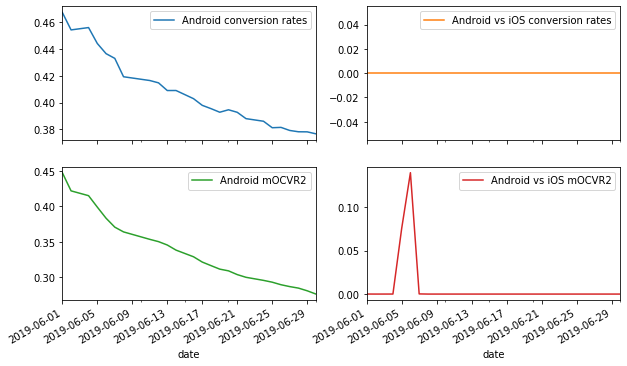

In [39]:
df_trended_cr = df_trended_cr[['p_value_cr_android', 'p_value_cr_android_ios', 'p_value_mocvr2_android', 'p_value_mocvr2_android_ios']]
df_trended_cr1 = df_trended_cr.reset_index()
df_trended_cr1['date'] = pd.to_datetime(df_trended_cr1['date'])
df_trended_cr1_plot = df_trended_cr1.melt(id_vars=['date'], value_vars = ['p_value_cr_android', 'p_value_cr_android_ios', 'p_value_mocvr2_android', 'p_value_mocvr2_android_ios'] , var_name='p_values')
df_trended_cr1_plot = df_trended_cr1_plot.groupby(['date', 'p_values']).agg({'value': ['sum']})
df_trended_cr1_plot = df_trended_cr1_plot.unstack(1)
df_trended_cr1_plot.columns = ['_'.join(tup).rstrip('_') for tup in df_trended_cr1_plot.columns.values]
df_trended_cr1_plot = df_trended_cr1_plot.rename(columns={"value_sum_p_value_cr_android": "Android conversion rates",
                           "value_sum_p_value_cr_android_ios": "Android vs iOS conversion rates",
                          "value_sum_p_value_mocvr2_android" : "Android mOCVR2",
                          "value_sum_p_value_mocvr2_android_ios" : "Android vs iOS mOCVR2"})
df_trended_cr1_plot.plot(subplots=True, layout=(2,2), figsize=(10,6))

plt.show()

_What is the p-value for experiment runtime and does it maintain the same dynamic over the reported timeframe?_

By the end of the experiment (30 June), the p-value for Android experiment conversion rates was 0.377. 
The p-value for iOS vs Android conversion rates was 0. The p-value for mOCVR2 on Android was 0.277 and the p-value for mOCVR2 on iOS vs Android was 0. 

The p-value for conversion rate on Android steadily decreases over time as the experiment progresses. The p-value for conversion rate for iOS remains steady since it was already zero since the start of the experiment.

The p-value for mOCVR2 on Android steadily decreases over time as the experiment progresses. The p-value for mOCVR2 on iOS only increased from 5-6th June but dropped back down to zero as the experiment progressed.

So, the variant isn't considered to perform better than the control on Android, but the iOS variant performs much better as compared to the control on Android.